In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#odeint is the numerical integration of ODEs through the scipy package
from scipy.integrate import odeint

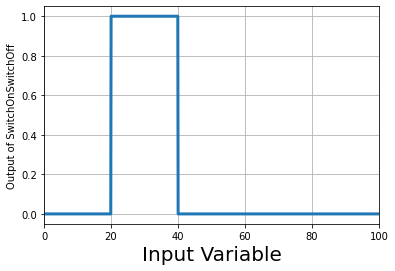

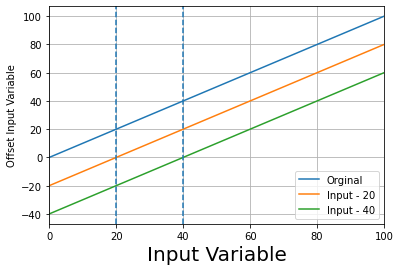

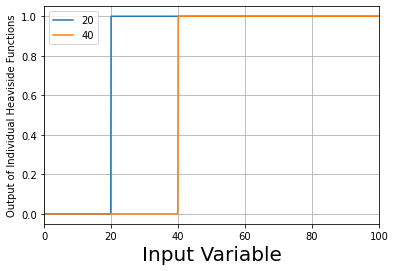

In [ ]:
def SwitchOnSwitchOff(T,Ton,Toff=np.inf): 
  '''
  Function takes an input T which can be a value or numpy array and outputs 1 
  if T>Ton and T<Toff. 

  If Toff is not provided, the function is assumed to stay on 
  '''
  return np.heaviside(T-Ton,0) - np.heaviside(T-Toff,0)

time = np.linspace(0,100,1000)
plt.plot(time,SwitchOnSwitchOff(time,20,40),linewidth=3)
plt.xlabel("Input Variable",size=20)
plt.ylabel("Output of SwitchOnSwitchOff")
plt.xlim([0,100])
plt.grid()

plt.figure()
plt.plot(time,time,label="Orginal")
plt.plot(time,time-20,label="Input - 20")
plt.plot(time,time-40,label="Input - 40")
plt.xlabel("Input Variable",size=20)
plt.ylabel("Offset Input Variable")
plt.axvline(20,ls='--')
plt.axvline(40,ls='--')
plt.xlim([0,100])
plt.legend()
plt.grid()

plt.figure()
plt.plot(time,SwitchOnSwitchOff(time,20),label="20")
plt.plot(time,SwitchOnSwitchOff(time,40),label="40")
plt.xlabel("Input Variable",size=20)
plt.ylabel("Output of Individual Heaviside Functions")
plt.xlim([0,100])
plt.legend()
plt.grid()

In [ ]:
def SimpleGeneRegulationTime(X,T,XTarget,
                             s_x_TimeOn,s_x_TimeOff, 
                             alpha_x = 100): 
    #Parameters for X ODE 
    s_x_Value = alpha_x*XTarget #Rate of production to get steady state value equal to Xtarget
    
    #Individual Rates for X  
    rate_production_x = s_x_Value*SwitchOnSwitchOff(T,s_x_TimeOn,s_x_TimeOff) 
    rate_decay_x = alpha_x*X 

    #ODE for species X
    X_ode =rate_production_x - rate_decay_x
    return X_ode

def SimpleGeneRegulationSpecies(Y,T,
                                X,
                                YTarget,X_Threshold, AlphaY): 
    #Parameters for X ODE 
    s_y_Value = AlphaY*YTarget #Rate of production to get steady state value equal to Ytarget
    
    #Individual Rates for X  
    rate_production_y = s_y_Value*SwitchOnSwitchOff(X,X_Threshold) 
    rate_decay_y = AlphaY*Y

    #ODE for species X
    Y_ode =rate_production_y - rate_decay_y
    return Y_ode

def ANDGateRegulation(Z,T,
                      X,Y,
                      Ztarget,X_Threshold,Y_Threshold, AlphaZ):
    #Parameters for X ODE 
    s_z_Value = AlphaZ*Ztarget #Rate of production to get steady state value equal to Ztarget
    
    #Individual Rates for X  
    rate_production_z = s_z_Value*(SwitchOnSwitchOff(X,X_Threshold) and SwitchOnSwitchOff(Y,Y_Threshold) )
    rate_decay_z= AlphaZ*Z

    #ODE for species X
    Z_ode =rate_production_z - rate_decay_z
    return Z_ode

def ORGateRegulation(Z,T,
                      X,Y,
                      Ztarget,X_Threshold,Y_Threshold, AlphaZ):
    #Parameters for X ODE 
    s_z_Value = AlphaZ*Ztarget #Rate of production to get steady state value equal to Ztarget
    
    #Individual Rates for X  
    rate_production_z = s_z_Value*(SwitchOnSwitchOff(X,X_Threshold) or SwitchOnSwitchOff(Y,Y_Threshold) )
    rate_decay_z= AlphaZ*Z

    #ODE for species X
    Z_ode =rate_production_z - rate_decay_z
    return Z_ode

#How do we code for a coherant feed forward loop with an AND Gate? 
def CFFL(Species,T,
         XTarget,s_x_TimeOn,s_x_TimeOff,
         YTarget,X_Threshold, AlphaY,
         Ztarget,Y_Threshold, AlphaZ,GateRegulation): 
    X,Y,Z = Species #Tuple unpacking of each species 
    
    #X is modeled through simple gene regulation 
    X_ode = SimpleGeneRegulationTime(X,T,XTarget,s_x_TimeOn,s_x_TimeOff)

    #Y is modeled through simple gene regulation by species X 
    Y_ode = SimpleGeneRegulationSpecies(Y,T,X,YTarget,X_Threshold,AlphaY)
    
    #Z 
    Z_ode = GateRegulation(Z,T,X,Y,Ztarget,X_Threshold,Y_Threshold, AlphaZ)
    
    dSpeciesdt = [X_ode,Y_ode,Z_ode] #Order of ODE must match the order specified in Y 
    
    return dSpeciesdt


In [ ]:
def PlotSpecies(Species,Time,Args): 
  #Unpacking the Species Matrix
  X = Species[:,0]
  Y = Species[:,1]
  Z = Species[:,2] 

  #Unpacking the Args 
  XTarget,s_x_TimeOn,s_x_TimeOff,YTarget,X_Threshold, AlphaY,Ztarget,Y_Threshold, AlphaZ,GateRegulation = Args

  #========================Top Plot=============================================
  plt.subplot(3,1,1)
  plt.plot(Time,X)
  plt.axhline(X_Threshold,c='orange',ls='--')
  plt.ylabel("X",size=20)
  plt.title(GateRegulation.__name__,size=20)
  #========================Middle Plot==========================================
  plt.subplot(3,1,2)
  plt.plot(Time,Y)
  plt.axvline(s_x_TimeOn,c='k',ls='--')
  plt.axvline(s_x_TimeOff,c='r',ls='--')
  plt.ylabel("Y",size=20)

  #Plot the Horzontal Line when the vector is reaching Y_Threshold
  plt.axhline(Y_Threshold,c='orange',ls='--')

  #Plotting the vertical line: 
  def GetIntersection(Y,Y_Threshold):
    Y_offset = Y - Y_Threshold

    #Is Y less than zero at time = 0? 
    y_sign_previous = Y_offset[0]<0

    Y_threshold_index = []
    for ith_test in range(1,len(Y_offset)): 
      y_sign_current = Y_offset[ith_test]<0
      if y_sign_current!=y_sign_previous: 
        Y_threshold_index.append(ith_test)
      y_sign_previous = y_sign_current

    return Y_threshold_index
  Y_threshold_index = GetIntersection(Y,Y_Threshold)
  for ith in Y_threshold_index:
    time_of_threshold = Time[ith]
    plt.plot([time_of_threshold,time_of_threshold],[0,Y_Threshold],c="orange",ls="--")

  #========================Bottom Plot==========================================
  plt.subplot(3,1,3)
  plt.plot(Time,Z)
  plt.ylabel("Z",size=20)
  plt.axvline(s_x_TimeOn,c='k',ls='--')
  plt.axvline(s_x_TimeOff,c='r',ls='--')

  #Same vertical line as the above 
  for ith in Y_threshold_index:
    time_of_threshold = Time[ith]
    plt.axvline(time_of_threshold,c='orange',ls='--')


  #========================General Features=====================================
  plt.xlabel("Time [Units]",size=20)
  plt.tight_layout()

In [ ]:
def RunAndPlot(X0,Y0,Z0,
               XTarget,s_x_TimeOn,s_x_TimeOff,
               YTarget,X_Threshold, AlphaY,
               Ztarget,Y_Threshold, AlphaZ,
               simulation_max,n_points,GateRegulation): 
  #Create the time array 
  t = np.linspace(0,simulation_max,n_points) 

  species_0 = [X0,Y0,Z0] 
  #Solving the ODE 
  argtuple = (XTarget,s_x_TimeOn,s_x_TimeOff,
              YTarget,X_Threshold, AlphaY,
              Ztarget,Y_Threshold, AlphaZ,GateRegulation)
  species = odeint(CFFL, species_0, t, args=argtuple,hmax=0.1)
  
  PlotSpecies(species,t,argtuple)

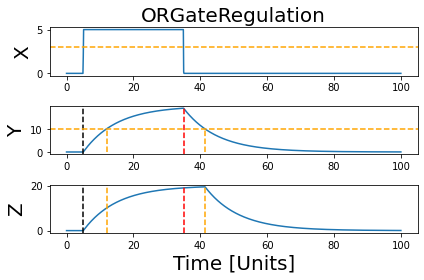

In [ ]:
'''
Before Running this cell for the first time. Ensure each cell above this one has 
been run in the current session!
'''

#Species Parameters 
X0 = 0 #Intial Concentration of X
Y0 = 0 #Intial Concentration of X
Z0 = 0 #Intial Concentration of X

#Model Parameters: 
XTarget      = 5    #Steady state concentration of X
YTarget      = 20   #Steady state concentration of Y
Ztarget      = 20   #Steady state concentration of Z

s_x_TimeOn   = 5    #Time in which X is turned on 
s_x_TimeOff  = 35   #Time in which X is turned off 

X_Threshold  = 3    #Threshold needed for X to cross to activate Y and/or Z
Y_Threshold  = 10   #Threshold needed for Y to cross to activate Z 

AlphaY       = 0.1 #Decay Rate of Y
AlphaZ       = 0.1 #Decay Rate of Z 



#Time Parameters: 
simulation_max = 100  #Maximum Simultion Time 
n_points       = 1000 #Minimum number of steps 

#Last Input can be an ORGateRegulation or ANDGateRegulation
RunAndPlot(X0,Y0,Z0,
           XTarget,s_x_TimeOn,s_x_TimeOff,
           YTarget,X_Threshold, AlphaY,
           Ztarget,Y_Threshold, AlphaZ,
           simulation_max,n_points,ORGateRegulation)